# Using Vision Language Models with transformers
You can infer with Llava using the LlavaNext model as shown below.

Let’s initialize the model and the processor first.

# References
- https://huggingface.co/blog/vlms#fine-tuning-vision-language-models-with-trl

Let’s initialize the model and the processor first.

In [1]:
import torch
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Model
- Required quantization to fit into a T4 (14GB)

In [3]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf",
    torch_dtype=torch.float16,
    
    quantization_config=quantization_config,
    low_cpu_mem_usage=True
)
# model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We now pass the image and the text prompt to the processor, and then pass the processed inputs to the generate.

 Note that each model uses its own prompt template, be careful to use the right one to avoid performance degradation.

# Example on Usage
- with image and prompt

In [19]:
from PIL import Image
import requests

def image_open(url:str):
    return Image.open(requests.get(url, stream=True).raw)

image = image_open("https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true")
prompt = "[INST] <image>\nWhat is shown in this image? [/INST]"

inputs = processor(prompt, image, return_tensors="pt").to(device)
output = model.generate(**inputs, max_new_tokens=400)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST]  
What is shown in this image? [/INST] The image appears to be a radar chart, which is a type of multi-dimensional plot that displays values for multiple quantitative variables represented on axes starting from the same point. This particular radar chart is showing the performance of various models or systems across different metrics or datasets.

The chart is divided into several sections, each representing a different model or dataset. The axes represent different metrics or datasets, such as "MMM-Vet," "MMM-Bench," "LLaVa-Bench," "SLED-Bench," "VizWiz," "TextVQA," "SQA-IMG," and "MMM-Bench-CN."

Each section of the chart shows the performance of the corresponding model or dataset on the various metrics. The colors and labels on the chart indicate the different models or datasets being compared.

The specific metrics or datasets are not labeled in the image, but they could be related to tasks such as image recognition, text understanding, or other forms of artificial intellige

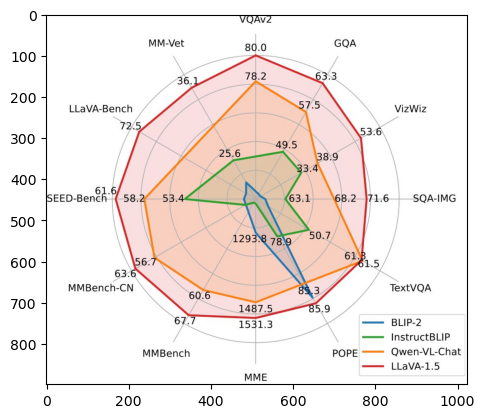

In [20]:
import matplotlib.pyplot as plt
plt.imshow(image)
print(processor.decode(output[0], skip_special_tokens=True))

Call decode to decode the output tokens.

In [31]:
image0 = image_open("http://images.cocodataset.org/val2017/000000039769.jpg")
prompt = "USER: <image>\nPlease describe this image\nASSISTANT:"
inputs = processor(prompt, image0, return_tensors="pt").to(device)
output = model.generate(**inputs, max_new_tokens=400)
# display(image1)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


USER:  
Please describe this image
ASSISTANT: The image shows two cats lying on a pink blanket. The cat on the left is a kitten with a gray and white striped coat, and it appears to be in a relaxed state, possibly sleeping. The cat on the right is a larger, orange and white tabby cat, also in a relaxed position. Between the two cats, there is a remote control, suggesting that the cats are in a living room setting. The cats are the main focus of the image, and their peaceful demeanor adds a sense of tranquility to the scene. 


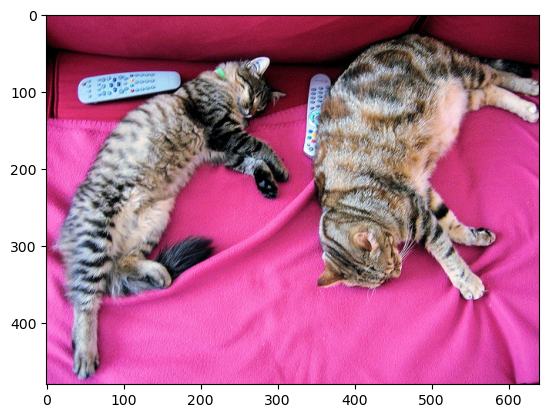

In [32]:
import matplotlib.pyplot as plt
plt.imshow(image0)
print(processor.decode(output[0], skip_special_tokens=True))

In [33]:
image0 = image_open("http://images.cocodataset.org/val2017/000000039769.jpg")
prompt = "USER: <image>\nPlease can you identify the bounding box and location of the cats?\nASSISTANT:"
inputs = processor(prompt, image0, return_tensors="pt").to(device)
output = model.generate(**inputs, max_new_tokens=400)
# display(image1)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


USER:  
Please can you identify the bounding box and location of the cats?
ASSISTANT: The image shows two cats lying on a pink surface. The cat on the left is lying on its side with its head resting on the surface. Its front legs are stretched out, and its tail is curled up. The cat on the right is lying on its back with its head resting on the surface. Its front legs are stretched out, and its tail is curled up. Both cats appear to be sleeping or resting. The cats are located on a pink surface, which could be a blanket or a cushion. There is a remote control next to the cat on the left. 


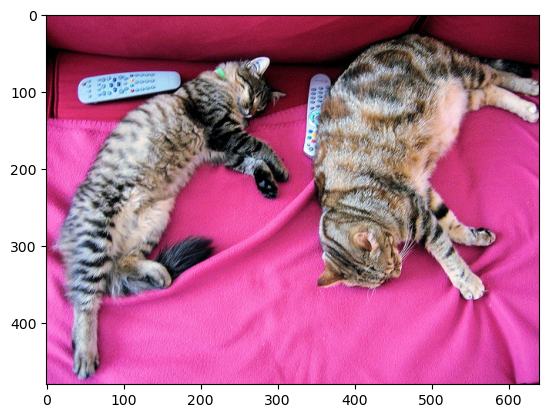

In [34]:
import matplotlib.pyplot as plt
plt.imshow(image0)
print(processor.decode(output[0], skip_special_tokens=True))

# With HuggingFace Pipeline API

In [22]:
from transformers import pipeline
pipe = pipeline("image-to-text", model='llava-hf/llava-v1.6-mistral-7b-hf', model_kwargs={"quantization_config": quantization_config})

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [26]:
image1 = image_open("https://llava-vl.github.io/static/images/view.jpg")
prompt = "USER: <image>\nWhat are the things I should be cautious about when I visit this place?\nASSISTANT:"
outputs = pipe(image1, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

USER:  
What are the things I should be cautious about when I visit this place?
ASSISTANT: When visiting a place like the one shown in the image, which appears to be a dock or pier extending into a body of water, there are several things you should be cautious about:

1. **Water Safety**: If you plan to swim or engage in water activities, make sure you are aware of the water conditions, currents, and any potential hazards.

2. **Weather Conditions**: Be prepared for changes in weather, as conditions can change rapidly in mountainous areas.

3. **Wildlife**: Depending on the location, there may be wildlife to be aware of, such as bears or other animals that could pose a risk.

4. **Emergency Preparedness**: Have a plan in case of an emergency. This includes knowing the location of the nearest medical facility and having a means of communication.

5. **Environmental Impact**: Be mindful of your environmental impact. Leave no trace of your visit


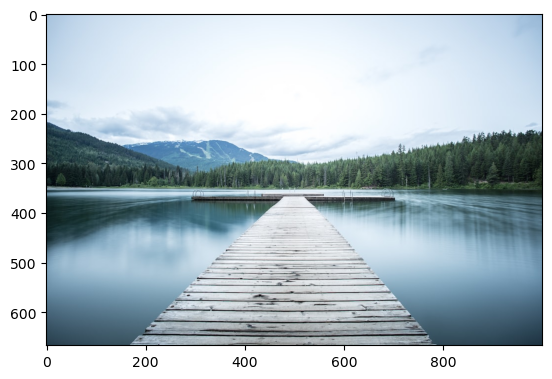

In [27]:
plt.imshow(image1)
print(outputs[0]["generated_text"])